In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [25]:
df_moving_avg = pd.read_csv("merged_fips_moving_average_data.csv")

In [26]:
df_moving_avg.drop(columns=['smoothed_wvaccine_likely_govt_health', 'smoothed_wwearing_mask'], inplace=True)

In [27]:
df_moving_avg['time_value'] = pd.to_datetime(df_moving_avg['time_value'])
df_moving_avg['month'] = df_moving_avg['time_value'].dt.month
df_moving_avg['week'] = df_moving_avg['time_value'].dt.isocalendar().week
df_moving_avg['dayofweek'] = df_moving_avg['time_value'].dt.dayofweek

In [28]:
df_moving_avg = df_moving_avg.sort_values(['FIPS County', 'time_value'])

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'max_depth': 15, 'max_features': 0.3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best CV R² Score: 0.986386737441077
Best Model - Test RMSE: 0.09
Best Model - Test R²: 0.998
   mean_test_score  mean_train_score  \
9         0.986387          0.990050   
8         0.986381          0.990108   
0         0.986168          0.990103   
1         0.986019          0.990043   
4         0.985277          0.989335   

                                              params  rank_test_score  
9  {'max_depth': 15, 'max_features': 0.3, 'min_sa...                1  
8  {'max_depth': 15, 'max_features': 0.3, 'min_sa...                2  
0  {'max_depth': 10, 'max_features': 0.3, 'min_sa...                3  
1  {'max_depth': 10, 'max_features': 0.3, 'min_sa...                4  
4  {'max_depth': 10, 'max_features': 'sqrt', 'min...                5  


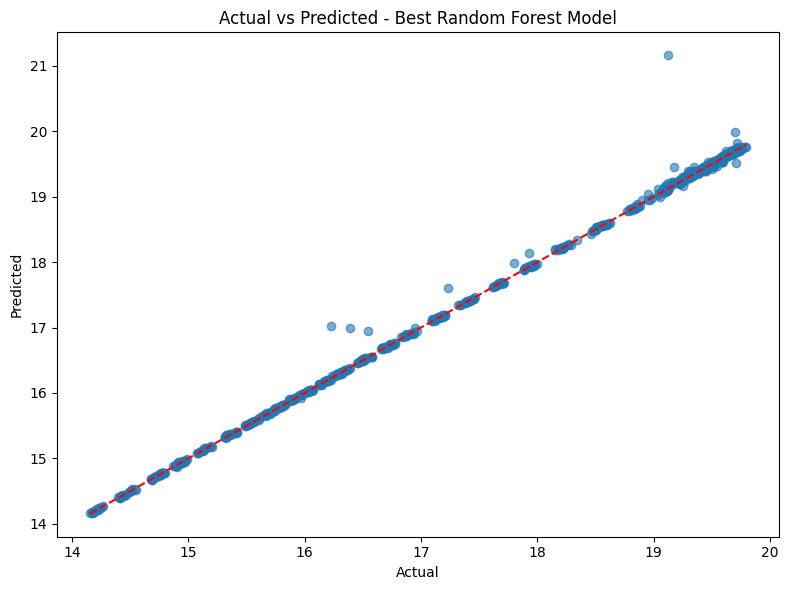

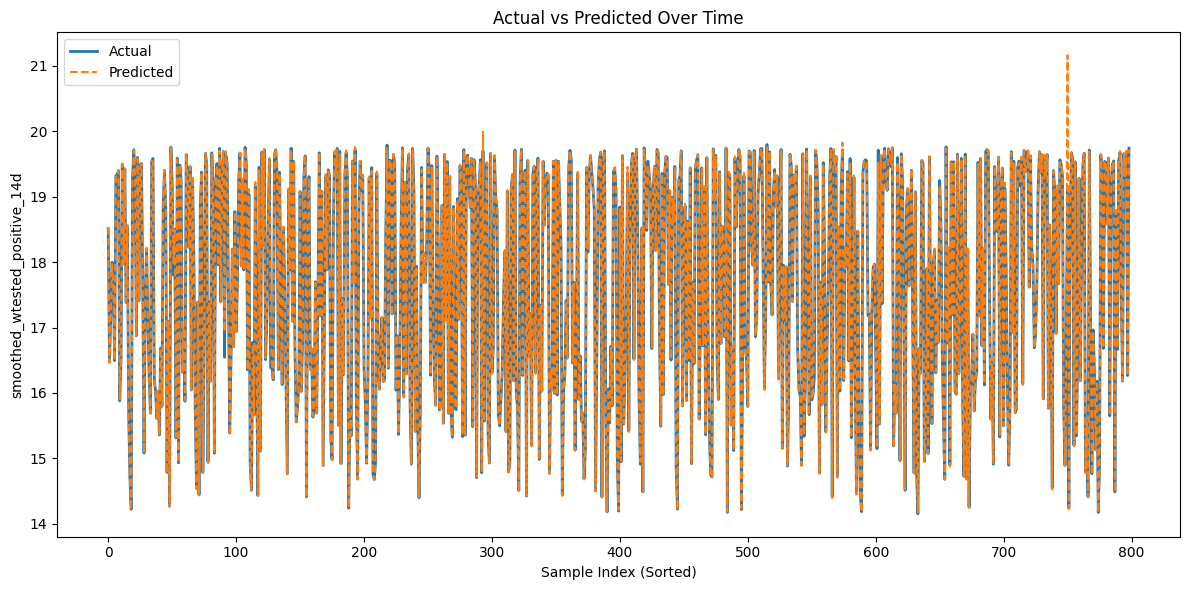

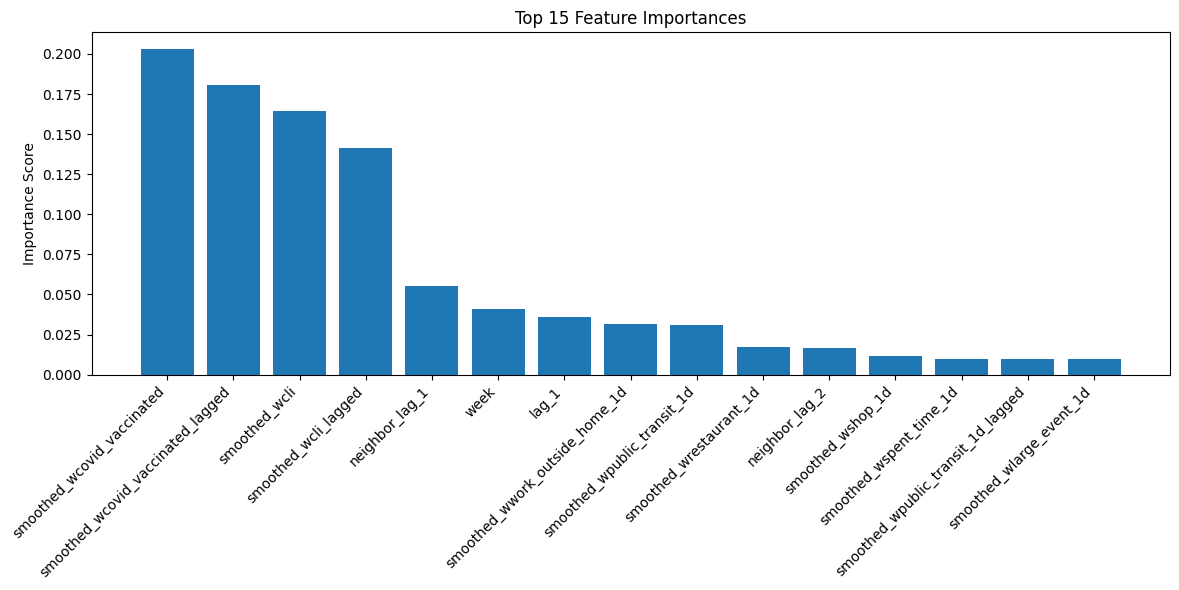

In [29]:
# Prepare lag features
df_moving_avg['time_value'] = pd.to_datetime(df_moving_avg['time_value'])
df_moving_avg = df_moving_avg.sort_values(['FIPS County', 'time_value'])

df_moving_avg['lag_1'] = df_moving_avg.groupby('FIPS County')['smoothed_wtested_positive_14d'].shift(1)
df_moving_avg['lag_2'] = df_moving_avg.groupby('FIPS County')['smoothed_wtested_positive_14d'].shift(2)

# Neighbor lag function
def compute_state_neighbor_lag(df, lag_col):
    neighbor_means = []
    for idx, row in df.iterrows():
        state = row['FIPS State']
        county = row['FIPS County']
        date = row['time_value']
        mask = (
            (df['time_value'] == date) &
            (df['FIPS State'] == state) &
            (df['FIPS County'] != county)
        )
        mean_val = df.loc[mask, lag_col].mean()
        neighbor_means.append(mean_val)
    return neighbor_means

# Apply neighbor lag computation
df_moving_avg['neighbor_lag_1'] = compute_state_neighbor_lag(df_moving_avg, 'lag_1')
df_moving_avg['neighbor_lag_2'] = compute_state_neighbor_lag(df_moving_avg, 'lag_2')

# Fill missing lags with same-day national average
lag_cols = ['neighbor_lag_1', 'neighbor_lag_2', 'lag_1', 'lag_2']
for col in lag_cols:
    daily_avg = df_moving_avg.groupby('time_value')[col].transform('mean')
    df_moving_avg[col] = df_moving_avg[col].fillna(daily_avg)

# Define features and target
drop_cols = ['time_value', 'geo_value', 'County Name', 'smoothed_wtested_positive_14d']
X = df_moving_avg.drop(columns=drop_cols)
y = df_moving_avg['smoothed_wtested_positive_14d']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# Random forest grid search
param_grid = {
    'n_estimators': [300],
    'max_depth': [10, 15],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [4, 8],
    'max_features': [0.3, 'sqrt']
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best CV R² Score:", grid_search.best_score_)

# Evaluate best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)

print(f"Best Model - Test RMSE: {rmse_best:.2f}")
print(f"Best Model - Test R²: {r2_best:.3f}")

# Show top grid results
cv_results = pd.DataFrame(grid_search.cv_results_)
top_r2 = cv_results.sort_values("mean_test_score", ascending=False).head()

print(top_r2[['mean_test_score', 'mean_train_score', 'params', 'rank_test_score']])

# Scatter plot: actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_best, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted - Best Random Forest Model")
plt.tight_layout()
plt.show()

# Line plot over sample index
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test.values, label='Actual', linewidth=2)
plt.plot(range(len(y_pred_best)), y_pred_best, label='Predicted', linestyle='--')
plt.xlabel("Sample Index (Sorted)")
plt.ylabel("smoothed_wtested_positive_14d")
plt.title("Actual vs Predicted Over Time")
plt.legend()
plt.tight_layout()
plt.show()

# Feature importance
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_train.columns

plt.figure(figsize=(12, 6))
plt.title("Top 15 Feature Importances")
plt.bar(range(15), importances[indices[:15]], align="center")
plt.xticks(range(15), [feature_names[i] for i in indices[:15]], rotation=45, ha="right")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()
